# Neural Machine Translation

Welcome to your last programming assignment of Course 5. You will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). After building a working Encoder-Decoder recurrent neural network, you are going to augment your model by adding attention mechanisms.

This notebook has been jointly produced by deeplearning.ai and NVIDIA's Deep Learning Institute (DLI).

Let's load all the packages you will need in this notebook.

In [2]:
from keras.layers import Embedding, Bidirectional
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.merge import Multiply
from keras.utils import to_categorical
from keras.layers import TimeDistributed
from keras.backend import int_shape

import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


## 1 - Translating human readable dates in machine readable dates

Although it is usually used to translate sentences from a source language (*e.g. Arabic*) to a target language (*e.g. Hindi*), Neural Machine Translation (NMT) has a wider range of applications. In this notebook, you are going to build an NMT to translate human readable dates (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) into machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). 

### 1.1 - Dataset

The dataset is a corpus of 1000 human readable dates and their equivalent machine readable dates. Let's run the following cell to load the dataset and print some information.

In [3]:
m = 1000
dataset, human_vocab, machine_vocab, inv_machine_vocab, sources, targets = create_dataset(m)

100%|██████████| 1000/1000 [00:00<00:00, 7627.62it/s]


You've loaded:
- dataset: a list of tuples (human readable date, machine readable date)
- human_vocab: a python dictionary mapping all characters used in human readable dates to an index (integer values)
- machine_vocab: a python dictionary mapping all characters used in machine readable dates to an index (integer values)
- inv_machine_vocab: the inverse dictionary of `machine_vocab`
- sources: a processed version of dataset's human readable dates, where each character is replaced by the integer value it is mapped to in the human_vocab, padded to $T_x$ values. `sources.shape = (m, Tx)`
- targets: a processed version of dataset's machine readable dates, where each character is replaced by the one-hot vector of the character it is mapped to in the machine_vocab, the date is also padded up to $T_x$. `targets.shape = (m, Tx, len(machine_vocab))`

Play with the index in the cell below to navigate in the dataset and see how source/target dates are preprocessed.

In [4]:
index = 12
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing:", sources[index])
print("Target after preprocessing:", targets[index])

Source date: 10/8/87
Target date: 1987-10-08

Source after preprocessing: [25 48 17 23 17 23 40 59 59 59 59 59 59 59 59 59 59 59 59 59]
Target after preprocessing: [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  

### 1.2 - Model architecture

Your NMT will use an encoder-decoder architecture. One training example's run through the model is explained in the figures below.

<img src="images/enc.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 1**: Simple NMT model (encoder part) </center></caption>

First, a preprocessed source date is encoded using a Bi-directional LSTM. The sequence of hidden states are returned and stored in an object called `enc_out`. `enc_out` is then given as an input sequence to the decoder which is described in the figure below.

<img src="images/dec.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 2**: Simple NMT model (decoder part) </center></caption>

The output vectors can then be compared to the ground truth using a categorical cross-entropy loss function. Minimizing this loss function will give you a trained NMT model. 

**Exercise**: Implement the `model_simple_nmt()` described in the figure below. The LSTMs both use 32 units. The embedding layer outputs a 64-dimensional embedding and should be trainable. These functions might be useful: Input(), [Embedding()](https://keras.io/layers/embeddings/), [LSTM()](https://keras.io/layers/recurrent/#lstm), [Bidirectional()](), [Dense()](https://keras.io/layers/core/#dense), [TimeDistributed()](https://keras.io/layers/wrappers/#timedistributed), [Model()](https://keras.io/models/model/).

In [5]:
def model_simple_nmt(human_vocab_size, machine_vocab_size, Tx = 20):
    """
    Simple Neural Machine Translation model
    
    Arguments:
    human_vocab_size -- size of the human vocabulary for dates, it will give us the size of the embedding layer
    machine_vocab_size -- size of the machine vocabulary for dates, it will give us the size of the output vector
    
    Returns:
    model -- model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx,))
    
    # Define the embedding layer. This layer should be trainable and the input_length should be set to Tx.
    input_embed = Embedding(human_vocab_size, 2*32, input_length = Tx, trainable=True)(inputs)
    
    # Encode the embeddings using a bidirectional LSTM
    enc_out = Bidirectional(LSTM(32, return_sequences=True))(input_embed)
    
    # Decode the encoding using an LSTM layer
    dec_out = LSTM(32, return_sequences=True)(enc_out)
    
    # Apply Dense layer to every time steps
    output = TimeDistributed(Dense(machine_vocab_size, activation='softmax'))(dec_out)
    
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your `model` and compile it.

In [6]:
# Create model
model = model_simple_nmt(len(human_vocab), len(machine_vocab))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`


Let's train this model for 200 epochs.

In [7]:
model.fit([sources], targets, epochs=1, batch_size=12, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 6s - loss: 1.6355 - acc: 0.5147 - val_loss: 1.2057 - val_acc: 0.5850


### 1.4 - Results

Try your simple NMT model on various examples using the code below.

In [8]:
### START CODE HERE ### (≈1 line)
example = "3rd of March 2001"
### END CODE HERE ###
source = string_to_int(example, 20, human_vocab)
prediction = model.predict(np.array([source]))
prediction = np.argmax(prediction[0], axis = -1)
output = int_to_string(prediction, inv_machine_vocab)
print("source:", example)
print("output:", ''.join(output))

source: 3rd of March 2001
output: 0000000--<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


As you can see, your NMT makes many mistakes, specially on long source dates such as *"3rd of March 1834"*. To overcome this, you are going to add an attention mechanism to your NMT.

## 2 - Improving results using attention

If you had to translate a book's paragraph from French to English, you would not read the whole paragraph then close the book and translate. You would first read the paragraph. Then, while translating, you would read and focus on parts of the paragraph corresponding to the parts you are currently translating.

Attention mechanism is technique in Deep Learning to help the model drive its focus on important parts of the input. In this part, you will augment your simple NMT with attention. 

### 2.1 - Attention models

Concretely, after running a source date in the encoder (Bi-LSTM), you would like to give all the hidden states to the decoder to get back the target date. However, at every step in the decoding process, you'd like your model to be able to tell which hidden state is more important to use.

[TEXT + FORMULAS + IMAGE PRESENTING THIS ATTENTION_3D_BLOCK]

In [9]:
def attention_3d_block(inputs):
    """
    Implement the attention block applied between two layers
    
    Argument:
    inputs -- output of the previous layer, set of hidden states
    
    Returns:
    output_attention_mul -- inputs weighted with attention probabilities
    """
    
    # Retrieve n_h and Tx from inputs' shape. Recall: inputs.shape = (m, Tx, n_h)
    Tx = int_shape(inputs)[1]
    n_h = int_shape(inputs)[2]
    
    ### START CODE HERE ###
    # Permute inputs' columns to compute "a" of shape (m, n_h, Tx)
    a = Permute((2, 1))(inputs)
    
    # Apply a Dense layer with softmax activation. It should contain Tx neurons. a.shape should still be (m, n_h, Tx).
    a = Dense(Tx, activation='softmax')(a)
    
    # Compute the mean of "a" over axis=1 (the "hidden" axis: n_h). a.shape should now be (m, Tx)
    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    
    # Repeat the vector "a" n_h times. "a" should now be of shape (m, n_h, Tx)
    a = RepeatVector(n_h)(a)
    
    # Permute the 2nd and the first column of a to get a probability vector of attention. a_probs.shape = (m, Tx, n_h)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Apply the attention probabilities to the "inputs" by multiplying element-wise.
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    ### END CODE HERE ###
    
    return output_attention_mul

In [10]:
import tensorflow as tf
n_h = 5
Tx = 2
m = 1
with tf.Session() as sess:
    """
    inputs = tf.Variable(np.random.randn(m,Tx,n_h))
    print(inputs.shape) # m,Tx,n_h
    a = Permute((2,1))(inputs)
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run(a))
    a = Reshape((n_h, Tx))(a)
    #print(sess.run(a))
    #a = Dense(Tx, activation='softmax')(a)
    #print(a.shape, "A") # m, n_h, Tx
    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    print(a.shape, "B") # m, Tx
    a = RepeatVector(n_h)(a)
    print(a.shape) # m, n_h, Tx
    a_probs = Permute((2, 1), name='attention_vec')(a)
    print(a_probs.shape, "C") # m, Tx, n_h
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    print(output_attention_mul.shape) # m, Tx, n_h
    """

### 2.2 - Assessing the efficiency of this attention block

In order to ensure that the activation block you have just coded is able to tell the model where to focus on, you are going to try an experiment.

Let's first generate datapoints $(X, Y) = $ {$(x^{(i)}, y^{(i)})_{i=1...m}$} such that:
- $y^{(i)}$ is a label equal to 0 or 1.
- $x^{(i)}$ is a matrix of shape $(T_x, n_h)$ where one column is equal to $y^{(i)}$  and the rest is random. It means that for some time-step "t", we have x[t,:] = y.
- Thus `X.shape =` $(m, T_x, n_h)$ and `Y.shape =` $(m, 1)$.

Run the cell below to see some examples of X and Y.

In [11]:
np.random.seed(1)
x, y = get_data_recurrent(m = 2, Tx = 4, n_h = 3, attention_column=None)
print("x.shape =", x.shape)
print("x =", x)
print()
print("y.shape =", y.shape)
print("y =", y)

x.shape = (2, 4, 3)
x = [[[-0.54974618 -1.40287272  1.5827523 ]
  [ 1.          1.          1.        ]
  [-1.50780766 -0.31529207  0.85817886]
  [ 0.07134299 -2.29230928 -1.41555249]]

 [[ 0.8858294   0.63190187  0.04026035]
  [ 1.          1.          1.        ]
  [-0.53524902  0.77735121  0.17133845]
  [-0.44285144  1.70490377  0.92434585]]]

y.shape = (2, 1)
y = [[1]
 [1]]


The dataset (X, Y) is useful to observe the impact of attention. Indeed, you will try a binary classifier that given x will predict y. Thanks to the attention mechanism, your network should understand that only one time-step of x is useful to predict y, the rest is random. Your model should focus solely on this particular time-step. Run the following cell to load the dataset with attention on the third time-step.

In [48]:
X, Y = get_data_recurrent(m = 10000, Tx = 10, n_h = 2, attention_column = 3)

#### 2.2.1 - Attention after an LSTM

The attention block can be mounted at different positions in the network. The most common positions are before and after an LSTM. Below, we are providing two different models with the attention block applied before and after the LSTM.

In [49]:
def model_attention_applied_before_lstm(Tx, n_h):
    """
    Model with attention applied before the LSTM
        
    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx, n_h,))
    # Add the attention block
    attention_mul = attention_3d_block(inputs)
    # Pass the inputs in a LSTM layer, return the sequence of hidden states
    attention_mul = LSTM(32, return_sequences=False)(attention_mul)
    # Apply Dense layer with sigmoid activation the output should be a single number.
    output = Dense(1, activation='sigmoid')(attention_mul)
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    return model

In [50]:
def model_attention_applied_after_lstm(Tx, n_x):
    """
    Model with attention applied after the LSTM
    
    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx, n_x,))
    # Pass the inputs in a LSTM layer, return the sequence of hidden states
    lstm_out = LSTM(32, return_sequences=True)(inputs)
    # Add the attention block
    attention_mul = attention_3d_block(lstm_out)
    # Flatten the output of the attention block
    attention_mul = Flatten()(attention_mul)
    # Apply Dense layer with sigmoid activation the output should be a single number.
    output = Dense(1, activation='sigmoid')(attention_mul)
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    return model

You will train the model with attention applied after the LSTM. Later on, you can come back and try the model with attention applied before the LSTM.

In [51]:
m = model_attention_applied_after_lstm(Tx = 10, n_x = 2)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Run the cell below to compile the model you've just created.

In [52]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Running the cell below will train your model over the (X, Y) dataset for 100 epochs and a batch size of 512.

In [55]:
m.fit([X], Y, epochs=10, batch_size=512, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 2s - loss: 0.3990 - acc: 0.8168 - val_loss: 0.3283 - val_acc: 0.8650
Epoch 2/10
9000/9000 [==============================] - 2s - loss: 0.3416 - acc: 0.8528 - val_loss: 0.2831 - val_acc: 0.8910
Epoch 3/10
9000/9000 [==============================] - 2s - loss: 0.3111 - acc: 0.8677 - val_loss: 0.2564 - val_acc: 0.9020
Epoch 4/10
9000/9000 [==============================] - 2s - loss: 0.2881 - acc: 0.8761 - val_loss: 0.2318 - val_acc: 0.9120
Epoch 5/10
9000/9000 [==============================] - 2s - loss: 0.2640 - acc: 0.8840 - val_loss: 0.2007 - val_acc: 0.9260
Epoch 6/10
9000/9000 [==============================] - 2s - loss: 0.2304 - acc: 0.8994 - val_loss: 0.1712 - val_acc: 0.9360
Epoch 7/10
9000/9000 [==============================] - 2s - loss: 0.1994 - acc: 0.9136 - val_loss: 0.1432 - val_acc: 0.9490
Epoch 8/10
9000/9000 [==============================] - 2s - loss: 0.1686 - a

To see if the attention actually works. Let's generate 200 training examples with `attention_column=3`. 

[@VALENTIN CAN YOU PLEASE CHECK IF THIS IS WORKING FOR YOU. IT DOESN'T WORK FOR ME, MY RESULTS ARE INCONSISTENT]

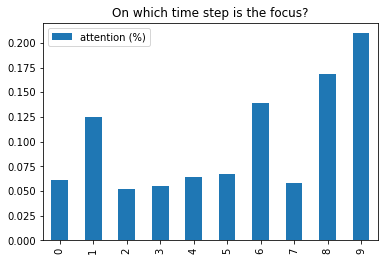

In [56]:
attention_vectors = []

for i in range(200):
    # Generate one training example (x, y), the attention column can be on any time-step.
    x, y = get_data_recurrent(m = 1, Tx = 10, n_h = 2)
    # Extract the attention vector predicted by the model "m" on the training example "x".
    attention_vector = np.mean(get_activations(m, x, layer_name='attention_vec')[0], axis=2).squeeze()
    # Append the attention vector to the list of attention vectors
    assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)

# Compute the average attention on every time-step
attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

# Plot
pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar', title='On which time step is the focus?')
plt.show()

### 2.3 - Adding Attention to your NTM

Now, it's time to add attention to the NMT model you've implemented in part (1). 

**Exercise**: Re-implement `model_simple_nmt()` but this time with attention.

In [ ]:
def model_attention_nmt(human_vocab_size, machine_vocab_size, Tx = 20):
    """
    Attention Neural Machine Translation model
    
    Arguments:
    human_vocab_size -- size of the human vocabulary for dates, it will give us the size of the embedding layer
    machine_vocab_size -- size of the machine vocabulary for dates, it will give us the size of the output vector
    
    Returns:
    model -- model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx,))
    
    # Define the embedding layer. This layer should be trainable and the input_length should be set to Tx.
    input_embed = Embedding(human_vocab_size, 2*32, input_length = Tx, trainable=True)(inputs)
    
    # Encode the embeddings using a bidirectional LSTM
    enc_out = Bidirectional(LSTM(32, return_sequences=True))(input_embed)
    
    # Add attention
    attention = attention_3d_block(enc_out)
    
    # Decode the encoding using an LSTM layer
    dec_out = LSTM(32, return_sequences=True)(attention)
    
    # Apply Dense layer to every time steps
    output = TimeDistributed(Dense(machine_vocab_size, activation='softmax'))(dec_out)
    
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    ### END CODE HERE ###
    
    return model

[CREATE MODEL + COMIPLING]

In [ ]:
# Create model
model_att = model_attention_nmt(len(human_vocab), len(machine_vocab))

# Compile model
model_att.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

[TRAINING]

In [ ]:
model_att.fit([sources], targets, epochs=1, batch_size=12, validation_split=0.1)

### Results

In [ ]:
### START CODE HERE ### (≈1 line)
example = "3rd of March 2001"
### END CODE HERE ###
source = string_to_int(example, 20, human_vocab)
prediction = model_att.predict(np.array([source]))
prediction = np.argmax(prediction[0], axis = -1)
output = int_to_string(prediction, inv_machine_vocab)
print("source:", example)
print("output:", ''.join(output))

### Visualizing Attention
[VISUALIZING ATTENTION ON A FEW EXAMPLES]

In [ ]:
def attention_map(model, input_vocabulary, inv_output_vocabulary, text):
    """
        visualization of attention map
    """
    # encode the string
    encoded = string_to_int(text, Tx, input_vocabulary)

    # get the output sequence
    prediction = model.predict(np.array([encoded]))
    predicted_text = np.argmax(prediction[0], axis=-1)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)

    text_ = list(text)
    # get the lengths of the string
    input_length = len(text)
    output_length = predicted_text.index('<pad>')
    # get the activation map
    attention_vector = get_activations(model, [encoded], layer_name='attention_vec')[0].squeeze()
    activation_map = attention_vector[0:output_length, 0:input_length]
    
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Probability', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    f.show()

In [ ]:
attention_map(model_att, human_vocab, inv_machine_vocab, EXAMPLES[0])

## 3 - BLEU SCORE + BEAM SEARCH

In [32]:
np.random.seed(4)
x, y = get_data_recurrent(m = 10, Tx = 10, n_h = 2, attention_column= 3)
pred = m.predict(x)
print(pred, y)
acc = m.evaluate([x], y)[1]
print(" Test accuracy =", acc)

[[ 0.0033319 ]
 [ 0.59544504]
 [ 0.00413279]
 [ 0.00315457]
 [ 0.00271449]
 [ 0.00771692]
 [ 0.97968459]
 [ 0.00281642]
 [ 0.00265952]
 [ 0.00314108]] [[1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]]
10/10 [==============================] - 0s
 Test accuracy = 0.699999988079


In [ ]:
def get_activations(model, inputs, layer_name=None):
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
    return activations

In [ ]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=None):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    if attention_column is None:
        attention_column = np.random.randint(low=0, high=input_dim)
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    print(x.shape)
    return x, y

In [ ]:
x1, y1 = get_data_recurrent(2, 6, 5, attention_column=None)
print(x1.shape)
print(y1.shape)

In [ ]:
INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = True

In [ ]:
def nmt_with_attention(human_vocab_size, machine_vocab_size, Tx = 20):
    """
    Simple Neural Machine Translation model
    
    Arguments:
    human_vocab_size -- size of the human vocabulary for dates, it will give us the size of the embedding layer
    machine_vocab_size -- size of the machine vocabulary for dates, it will give us the size of the output vector
    
    Returns:
    model -- model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx,))
    
    # Define the embedding layer. This layer should be trainable and the input_length should be set to Tx.
    input_embed = Embedding(human_vocab_size, 2*32, input_length = Tx, trainable=True)(inputs)
    
    # Encode the embeddings using a bidirectional LSTM
    enc_out = Bidirectional(LSTM(32, return_sequences=True))(input_embed)
    
    # Decode the encoding using an LSTM layer
    dec_out = LSTM(32, return_sequences=True)(enc_out)
    
    # Apply Dense layer to every time steps
    output = TimeDistributed(Dense(machine_vocab_size, activation='softmax'))(dec_out)
    
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    ### END CODE HERE ###
    
    return model

In [ ]:
def attention_3d_block(inputs):
    """
    Adds attention to the given input
    
    Argument:
    inputs --
    
    Returns:
    output_attention_mul --
    
    """
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, Tx))(a)
    a = Dense(Tx, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    return output_attention_mul

In [ ]:
def model_attention_applied_after_lstm():
    """
    Model with attention applied after the LSTM
    
    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx, INPUT_DIM,))
    # Pass the inputs in a LSTM layer, return the sequence of hidden states
    lstm_out = LSTM(32, return_sequences=True)(inputs)
    # Add the attention block
    attention_mul = attention_3d_block(lstm_out)
    # Flatten the output of the attention block
    attention_mul = Flatten()(attention_mul)
    # Apply Dense layer with sigmoid activation the output should be a single number.
    output = Dense(1, activation='sigmoid')(attention_mul)
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    return model

In [ ]:
def model_attention_applied_before_lstm():
    """
    Model with attention applied before the LSTM
        
    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx, INPUT_DIM,))
    # Add the attention block
    attention_mul = attention_3d_block(inputs)
    # Pass the inputs in a LSTM layer, return the sequence of hidden states
    attention_mul = LSTM(32, return_sequences=False)(attention_mul)
    # Apply Dense layer with sigmoid activation the output should be a single number.
    output = Dense(1, activation='sigmoid')(attention_mul)
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    return model

In [ ]:
N = 10000#300000
INPUT_DIM = 2
APPLY_ATTENTION_BEFORE_LSTM = False
SINGLE_ATTENTION_VECTOR = True

inputs_1, outputs = get_data_recurrent(N, Tx, INPUT_DIM)

if APPLY_ATTENTION_BEFORE_LSTM:
    m = model_attention_applied_before_lstm()
else:
    m = model_attention_applied_after_lstm()

m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

### 3.3 - Check your attention model 

In [ ]:
m.fit([inputs_1], outputs, epochs=1, batch_size=512, validation_split=0.1)

attention_vectors = []
for i in range(300):
    testing_inputs_1, testing_outputs = get_data_recurrent(1, Tx, INPUT_DIM)
    attention_vector = np.mean(get_activations(m,
                                               testing_inputs_1,
                                               layer_name='attention_vec')[0], axis=2).squeeze()
    #print('attention =', attention_vector)
    assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)

attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

# plot part.
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                     title='Attention Mechanism as '
                                                                           'a function of input'
                                                                           ' dimensions.')
plt.show()

## 4 - Implement Beam Search

In [ ]:
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import numpy as np

In [ ]:
fake = Faker()
fake.seed(12345)
random.seed(12345)

FORMATS = ['short',
           'medium',
           'long',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

In [ ]:
def create_date():
    """
        Creates some fake dates 
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS), locale=random.choice(LOCALES))

        case_change = random.choice([0,1,2])
        if case_change == 1:
            human_readable = human_readable.upper()
        elif case_change == 2:
            human_readable = human_readable.lower()
        # if case_change == 0, do nothing

        machine_readable = dt.isoformat()
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

In [ ]:
def create_dataset(n_examples):
    """
        Creates a dataset with n_examples and vocabularies
        :n_examples: the number of examples to generate
    """
    human_vocab = set()
    machine_vocab = set()
    dataset = []

    for i in tqdm(range(n_examples)):
        h, m, _ = create_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))

    human = dict(zip(list(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(list(machine_vocab) + ['<unk>', '<pad>']))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [ ]:
def string_to_int(string, lenght, vocab):
    if len(string) > lenght:
        string = string[:lenght]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < lenght:
        rep += [vocab['<pad>']] * (lenght - len(string))
    
    return rep

In [ ]:
def int_to_string(ints, inv_vocab):
    return [inv_vocab[i] for i in ints]

In [ ]:
N = 10000 #300000
dataset, human_vocab, machine_vocab, inv_machine_vocab = create_dataset(N)

In [ ]:
m = model_simple_nmt(len(human_vocab), len(machine_vocab))

m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(m.summary())

In [ ]:
inputs, targets = zip(*dataset)
inputs = np.array([string_to_int(i, Tx, human_vocab) for i in inputs])
targets = [string_to_int(t, Tx, machine_vocab) for t in targets]
targets = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), targets)))

In [ ]:
m.fit([inputs], targets, epochs=1, batch_size=64, validation_split=0.1)

In [ ]:
def keras_rnn_predict(samples, empty=human_vocab["<pad>"], rnn_model=m, maxlen=30):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty)
    return rnn_model.predict(data, verbose=0)

Here we'll try to generate some dates out of our model to demostrate beam search properties:

In [ ]:
def beamsearch(predict=keras_rnn_predict, k=1, maxsample=10, 
               use_unk=False, 
               oov=human_vocab["<unk>"], 
               empty=human_vocab["<pad>"], 
               eos=human_vocab["<unk>"]):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[empty]]
    live_scores = [0]

    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return live_samples + dead_samples, live_scores + dead_scores

## 5 - BLEU score

In this last part, you are going to implement the BLEU score to assess the effectiveness 

In [ ]:
def model_simple_nmt(in_chars, out_chars):
    inputs = Input(shape=(TIME_STEPS,))
    
    input_embed = Embedding(in_chars, ENCODER_UNITS * 2, input_length=TIME_STEPS, trainable=True,
                            name='embedding')(inputs)
    
    enc_out = Bidirectional(LSTM(ENCODER_UNITS, return_sequences=True))(input_embed)
    dec_out = LSTM(DECODER_UNITS, return_sequences=True)(enc_out)
    attention_mul = attention_3d_block(dec_out)
    
    output = TimeDistributed(Dense(out_chars, activation='softmax'))(attention_mul)
   
    model = Model(input=[inputs], output=output)
    return model

In [ ]:
from bleu import compute_bleu

EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007']
GROUND_TRUTH = ['1979-05-03', '2009-04-05', '2016-02-20', '2007-07-10']

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, Tx, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, samples=(EXAMPLES, GROUND_TRUTH)):
    predicted = []
    examples, targets = samples
    assert len(examples) == len(targets)
    
    for i, example in enumerate(examples):
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('input:', example)
        print('output:', predicted[i])
        print("BLEU score: ", compute_bleu([[ch for ch in targets[i]]], [ch for ch in predicted[i]])[0])
    return predicted

In [ ]:
run_examples(m, human_vocab, inv_machine_vocab)

In [ ]:
def attention_map(model, input_vocabulary, inv_output_vocabulary, text):
    """
        visualization of attention map
    """
    # encode the string
    encoded = string_to_int(text, Tx, input_vocabulary)

    # get the output sequence
    prediction = model.predict(np.array([encoded]))
    predicted_text = np.argmax(prediction[0], axis=-1)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)

    text_ = list(text)
    # get the lengths of the string
    input_length = len(text)
    output_length = predicted_text.index('<pad>')
    # get the activation map
    attention_vector = get_activations(model, [encoded], layer_name='attention_vec')[0].squeeze()
    activation_map = attention_vector[0:output_length, 0:input_length]
    
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Probability', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    f.show()

In [ ]:
attention_map(m, human_vocab, inv_machine_vocab, EXAMPLES[0])